# Using this Notebook:
**This notebook can be used to access the full version of the Rapid-Rescue model. Place the src directory and data directory in the same parent directory. Please retain all files in the src and data directories.** 

**In order to use this this notebook, set the information in the query below and then run all cells.**

In [1]:
# Standard Imports
from itertools import chain
import cPickle as pickle
import pandas as pd
import numpy as np
from ast import literal_eval
import multiprocessing
from timeit import Timer
import matplotlib.pyplot as plt
% matplotlib inline
# Imports from src directory
from Poisson import PoissonModel
from allocation import allocator
from hist_retrieval import hist_retriever
from allocation import allocator
from clustering import clusterer

# Importing Model:
**If you experience difficulties loading the pickled model, run Poisson.py from your command line and it will create a new pickled model that will be compatible with your environment.**

In [11]:
# Create a Dataframe and drop extra column
df1 = pd.read_csv('../data/seattle_911_prepped_no_out1.csv', low_memory=False)
df1.drop(['Unnamed: 0'], axis=1, inplace=True)
df2 = pd.read_csv('../data/seattle_911_prepped_no_out2.csv', low_memory=False)
df2.drop(['Unnamed: 0'], axis=1, inplace=True)
df = pd.concat([df1, df2])
# Load pickled Poisson model
with open('PoissonModel.pkl', 'rb') as pkl_object:
    model = pickle.load(pkl_object)   

# Functions:
**Run the below cell to define the necassary functions:**

In [3]:
def get_history(df, query):
    # Set get home game info from user_data
    mariners, seahawks, sounders = 0,0,0
    if query['home_game'] == 'mariners':
        mariners = 1
    if query['home_game'] == 'seahawks':
        seahawks = 1
    if query['home_game'] == 'sounders':
        sounders = 1
    # Create History DataFrames for each zone
    df1 = hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone1')
    df2 = hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone2')
    df3 = hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone3')
    df4 =  hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone4')
    df5 =  hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone5')
    df6 = hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone6')
    df7 =  hist_retriever(df, mariners, seahawks, sounders, query['date_input'],
                             query['time_range'], 'zone7')
    return df1, df2, df3, df4, df5, df6, df7


def get_centroids(df1, df2, df3, df4, df5, df6, df7, alloc, query):
    limit = query['limit']
    # Count cores and create pool object for multiprocessing
    cores = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(cores)
    # Generate iterable arguments for pool
    datas = [[df1, int(alloc['zone1']), limit], [df2, int(alloc['zone2']), limit], 
             [df3, int(alloc['zone3']), limit], [df4, int(alloc['zone4']), limit], 
             [df5, int(alloc['zone5']), limit], [df6, int(alloc['zone6']), limit],
             [df7, int(alloc['zone7']), limit]]
    # Find centoids using clusterer function
    output = pool.map(clusterer, datas)
    centroids = list(chain(output[0][0], output[1][0], output[2][0],
                           output[3][0], output[4][0], output[5][0],
                           output[6][0]))
    return centroids


def make_centroid_df(centroids):
    # Convert list of tuples into DataFrame
    centroid_df = pd.DataFrame(centroids)
    centroid_df.columns = ['Latitude', 'Longitude']
    centroid_df.index += 1
    return centroid_df


def make_plot(df1, df2, df3, df4, df5, df6, df7, centroid_df):
    # Plot historical data against optimal unit placements
    plt.figure(figsize=(16.96,25))
    plt.scatter(x=df1.Longitude, y=df1.Latitude, color='m', s=30, alpha=0.4)
    plt.scatter(x=df2.Longitude, y=df2.Latitude, color='orange', s=30, alpha=0.4)
    plt.scatter(x=df3.Longitude, y=df3.Latitude, color='#38d159', s=30, alpha=0.4)
    plt.scatter(x=df4.Longitude, y=df4.Latitude, color='b', s=30, alpha=0.4)
    plt.scatter(x=df5.Longitude, y=df5.Latitude, color='r', s=30, alpha=0.4)
    plt.scatter(x=df6.Longitude, y=df6.Latitude, color='#53cfd6', s=30, alpha=0.4)
    plt.scatter(x=df7.Longitude, y=df7.Latitude, color='#868591', s=30, alpha=0.4)
    plt.scatter(centroid_df.Longitude, centroid_df.Latitude, s=300, color='k')
    plt.xlabel('Longitude', fontsize=28, fontweight='bold')
    plt.xticks(fontsize=20)
    plt.ylabel('Latitude', fontsize=28, fontweight='bold')
    plt.yticks(fontsize=20)
    plt.title('Seattle 911 Responses by Zone', fontsize=36, fontweight='bold')
    plt.legend(['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 
                'Zone 5', 'Zone 6', 'Zone 7', 'Units'], fontsize=18)
    # To save plot, uncomment line below and create images directory in parent directory
    # plt.savefig('../images/plot911.png')

# Query:
**The query is used to request information from the model. Descriptions of the fields are below:**

** query = {'date_input': '2016-11-22', 'num_units': 25, 'home_game': 'no_game', 'time_range': 1, 'limit':None}  **

* date_imput is the string of the date in format 'YYYY-MM-DD'
* num_units represents the number of emergency response units to distribute around the city (integer between 1 and 100)
* home_game indicates type of home game on the date, allowed values are the following strings 'mariners', 'seahawks', 'sounders', 'no_game'
* time_range can either be 0 or 1 and 0 indicates 6am-6pm (day) and 1 indicates 6pm-6am (night)
* limit is used to limit how many points are used for calculating the optimal locations, None imposes no limit while an integer sets limits. Lower numbers calculate faster, but descrease precision. It is not recommend to go below 500


In [16]:
query = {'date_input': '2016-10-24', 'num_units': 24, 'home_game': 'no_game', 
         'time_range': 1, 'limit':None}

# Predicted Emergencies:
**Run the below cell to calculate the predicted number of medical emergencies in each zone for the 12 hour window requested.**

In [17]:
preds = model.predict(query)
preds

[('zone1', 26.684824771533485),
 ('zone2', 21.378874307467704),
 ('zone3', 14.290031473596137),
 ('zone4', 25.269030192204276),
 ('zone5', 33.653851805873465),
 ('zone6', 17.446506502443555),
 ('zone7', 24.267403911475906)]

# Resource Allocation:
**Run the below cell to determine the emergency response unit allocations to each zone of the city.**

In [18]:
alloc = allocator(query["num_units"], preds)
alloc

{'zone1': 3.0,
 'zone2': 4.0,
 'zone3': 4.0,
 'zone4': 3.0,
 'zone5': 4.0,
 'zone6': 3.0,
 'zone7': 3.0}

# Optimal Locations:
**Run the two cells below to determine the optimal locations for the emergency response units. Note that calculations for over 40 units may take a few minutues unless a limit is used in the query.**

In [19]:
%%time
df1,df2,df3,df4,df5,df6,df7 = get_history(df, query)
centroids = get_centroids(df1, df2, df3, df4, df5, df6, df7, alloc, query)
centroid_df = make_centroid_df(centroids)

data length = 2742
converged after 9 iterations
data length = 4236
converged after 14 iterations
data length = 6376
converged after 4 iterations
data length = 5317
converged after 15 iterations
data length = 4754
converged after 23 iterations
data length = 3558
converged after 9 iterations
data length = 4751
converged after 10 iterations
CPU times: user 412 ms, sys: 48 ms, total: 460 ms
Wall time: 2.77 s


In [20]:
centroid_df

,Latitude,Longitude
1,47.713049,-122.347418
2,47.664331,-122.341560
3,47.678867,-122.376701
4,47.678083,-122.280054
5,47.721838,-122.297415
6,47.663318,-122.310390
7,47.703615,-122.317525
8,47.624107,-122.353735
9,47.626752,-122.332982
10,47.640159,-122.360698


# Making a Plot:
**Run the cell below to generate a plot of the optimal locations for the emergency response units.**

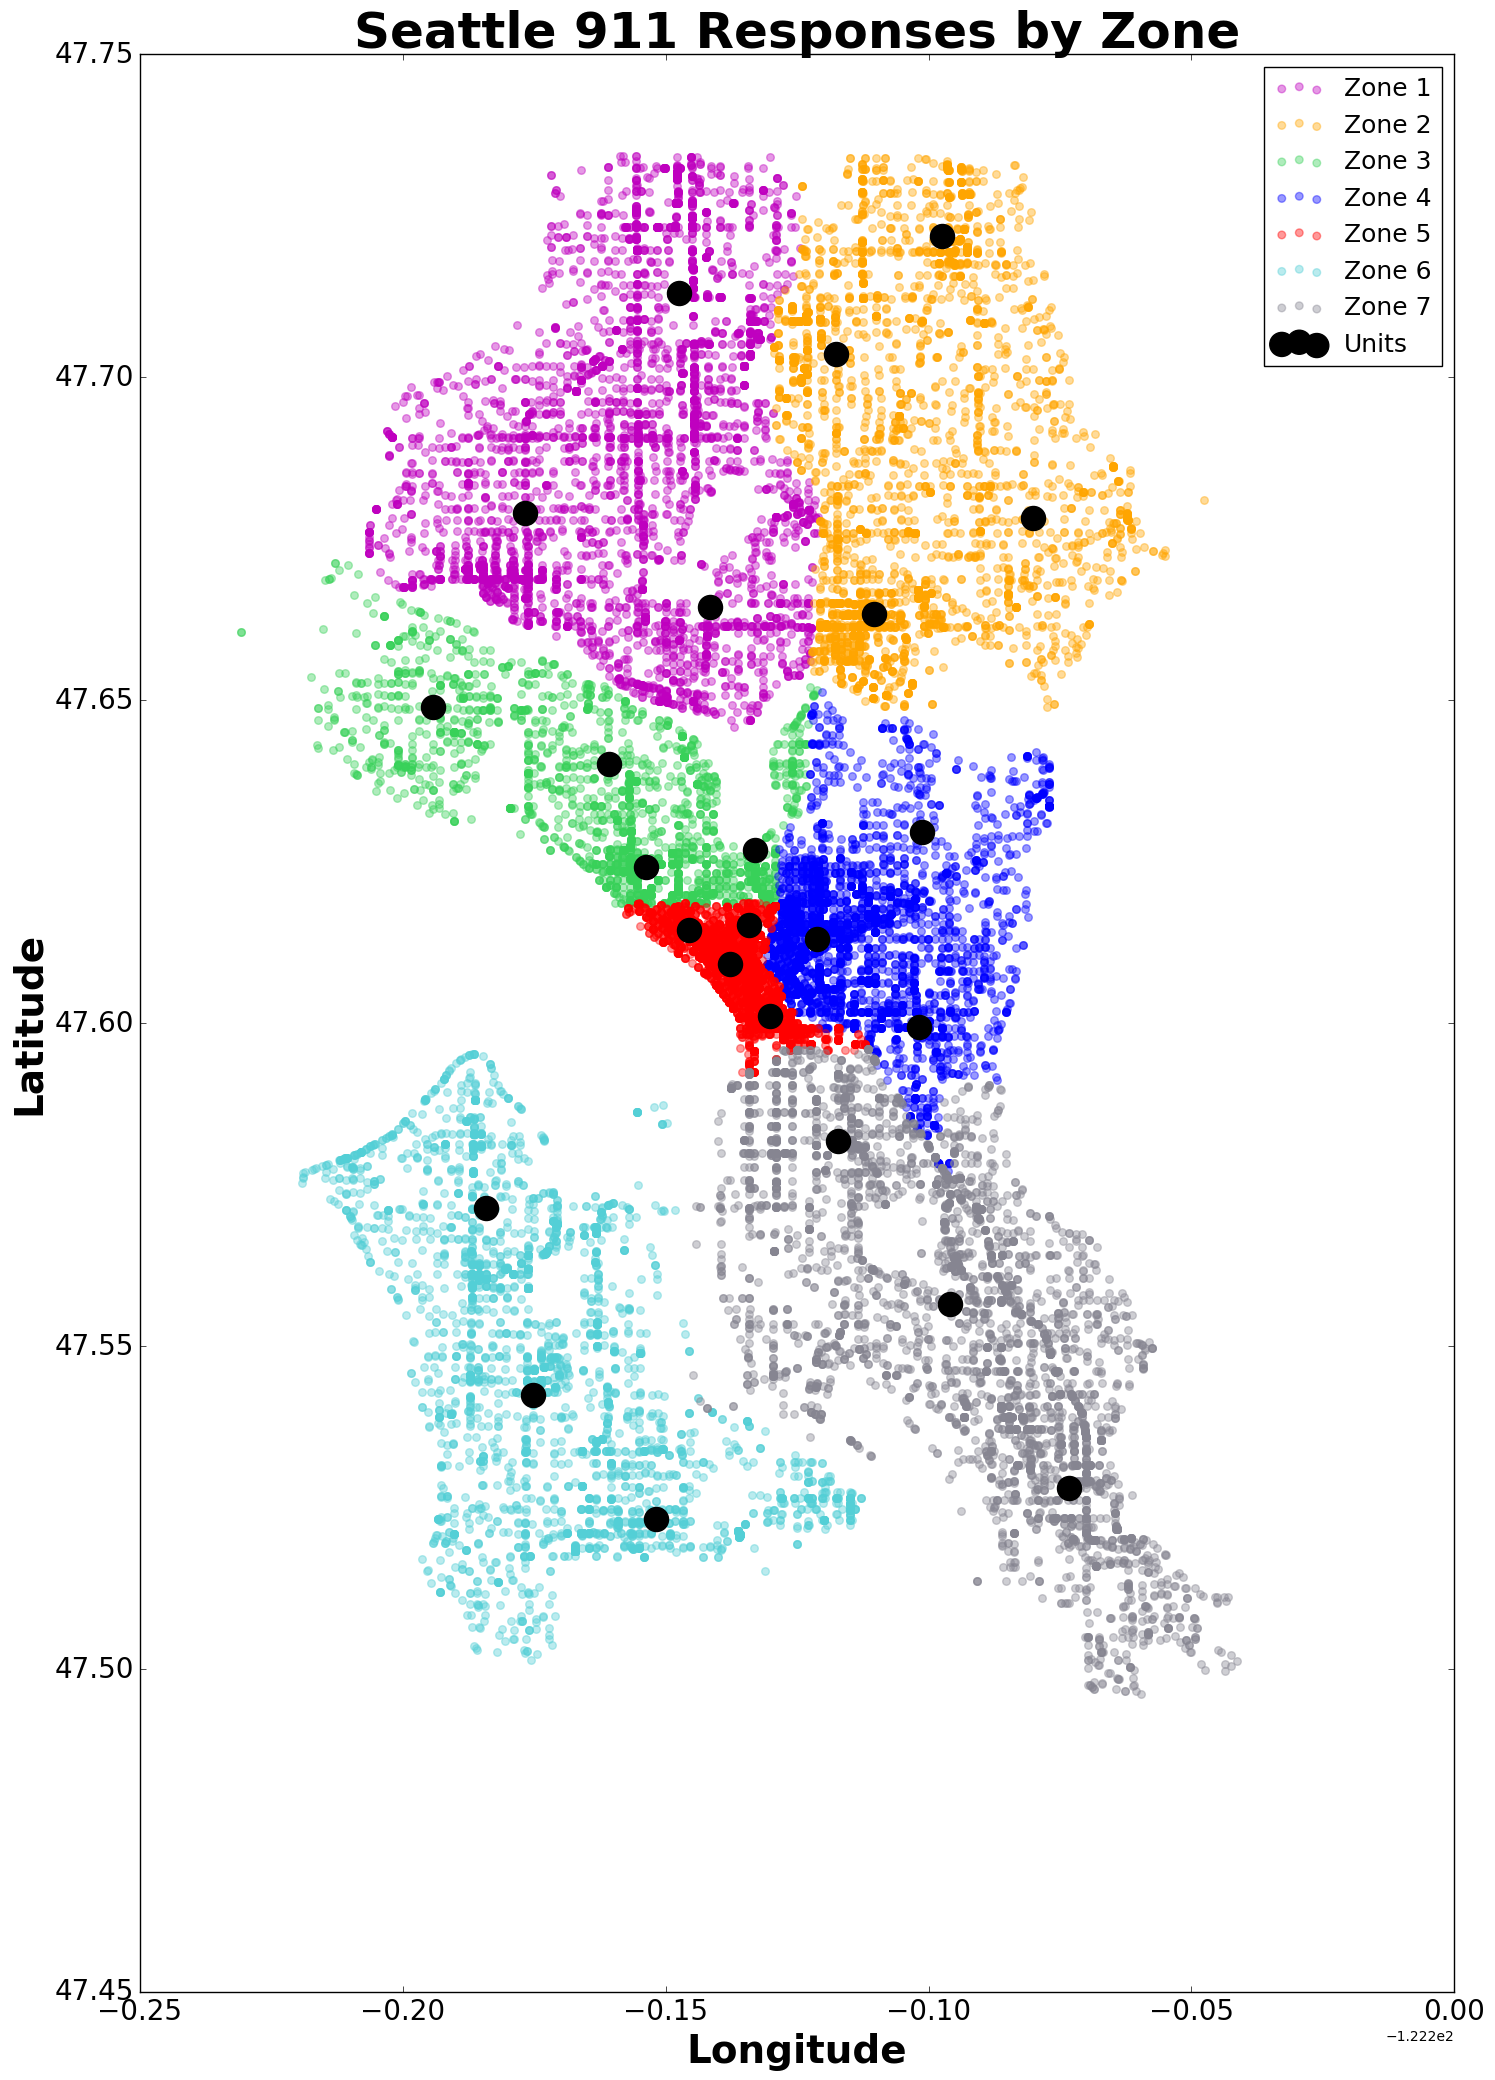

In [45]:
make_plot(df1, df2, df3, df4, df5, df6, df7, centroid_df)